## 2.1 perceptual hashing

In [1]:
# ! pip install imagehash

In [ ]:
from PIL import Image
import imagehash
from pathlib import Path

folder = Path("../data/media")
files = sorted(folder.iterdir())  # each is a Path object

hashes = {}
bad_files = []

for p in files:
    if not p.is_file():
        continue  # skip subdirectories etc.

    try:
        # Some files may be palette / RGBA, convert to RGB for consistency
        with Image.open(p) as img:
            img = img.convert("RGB")
            h = imagehash.phash(img)
        hashes[p.name] = h
    except Exception as e:
        # record bad files
        bad_files.append((p.name, str(e)))

print("Total files:", len(files))
print("Hashed images:", len(hashes))
print("Bad images:", len(bad_files))
bad_files[:5]


Total files: 44482
Hashed images: 44436
Bad images: 46


[('3_644461084502528000.jpg',
  "cannot identify image file '/Users/yuezhou/GitHubProjects/Social-data-mining/data/media/3_644461084502528000.jpg'"),
 ('3_671241218081296384.jpg',
  "cannot identify image file '/Users/yuezhou/GitHubProjects/Social-data-mining/data/media/3_671241218081296384.jpg'"),
 ('3_671279662459416577.jpg',
  "cannot identify image file '/Users/yuezhou/GitHubProjects/Social-data-mining/data/media/3_671279662459416577.jpg'"),
 ('3_671287718702379008.jpg',
  "cannot identify image file '/Users/yuezhou/GitHubProjects/Social-data-mining/data/media/3_671287718702379008.jpg'"),
 ('3_671319295956242432.jpg',
  "cannot identify image file '/Users/yuezhou/GitHubProjects/Social-data-mining/data/media/3_671319295956242432.jpg'")]

We used perceptual hashing (64-bit pHash) and grouped images whose hashes differ by at most 5 bits. Distances in [0,5] typically correspond to near-duplicates (small crops, color or compression changes), while larger distances often reflect different images. We inspected a few sample groups and found that 5 offered a good balance between avoiding false merges and capturing analytically equivalent images.

In [3]:
import random

image_files = list(hashes.keys())
random.seed(42)
sample_files = random.sample(image_files, 5000)

threshold = 5 # Hamming distance threshold
groups = []
assigned = set()

for i, f1 in enumerate(sample_files):
    if f1 in assigned:
        continue
    group = [f1]
    assigned.add(f1)

    for f2 in sample_files[i+1:]:
        if f2 in assigned:
            continue
        if hashes[f1] - hashes[f2] <= threshold:
            group.append(f2)
            assigned.add(f2)

    groups.append(group)


In [4]:
# group lengths
group_sizes = [(i, len(g)) for i, g in enumerate(groups)]
group_sizes_sorted = sorted(group_sizes, key=lambda x: x[1], reverse=True)

print("Top 15 largest groups:")
for gid, size in group_sizes_sorted[:15]:
    print(f"Group {gid}: {size} images")


Top 15 largest groups:
Group 7: 46 images
Group 43: 36 images
Group 13: 30 images
Group 287: 17 images
Group 256: 13 images
Group 323: 11 images
Group 780: 11 images
Group 705: 10 images
Group 684: 9 images
Group 28: 8 images
Group 827: 8 images
Group 853: 7 images
Group 2166: 7 images
Group 296: 6 images
Group 297: 6 images


In [ ]:
# largest group files
largest_gid = group_sizes_sorted[0][0]
largest_group_files = groups[largest_gid]

print("Files in the largest group:")
for f in largest_group_files[:20]:   
    print(f)


Files in the largest group:
3_671538017035776000.png
3_671531975988088833.png
3_671513850794123264.png
3_671579289800822784.png
3_671502920911855616.png
3_671585231284125696.png
3_671618162564177921.png
3_671538921818468352.png
3_671492649807908866.png
3_671499953324351489.png
3_671624426060955648.png
3_671615614646157312.png
3_671618355154042880.png
3_671593368095469568.png
3_671620219643801600.png
3_671615837908901888.png
3_671541124960493569.png
3_671606913612824580.png
3_671605163669475328.png
3_671615188743909376.png


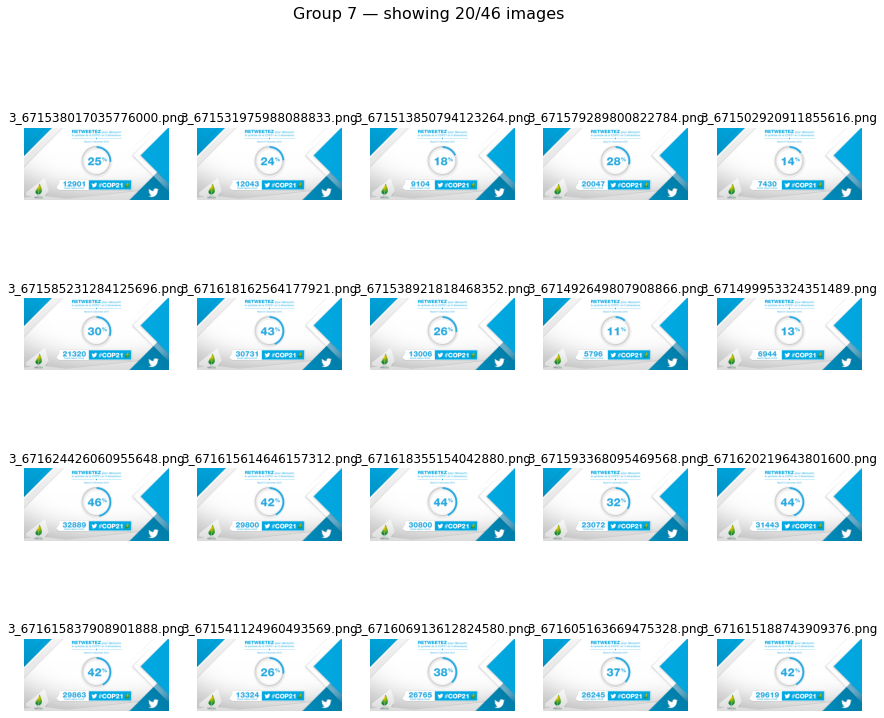

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import math
import os

folder = "../data/media/"  

def show_group_images(group_id, max_images=30):
    files = groups[group_id]
    n = min(len(files), max_images)

    cols = 5  # 5 figures per row
    rows = math.ceil(n / cols)

    plt.figure(figsize=(15, 3 * rows))

    for i, f in enumerate(files[:n]):
        img_path = os.path.join(folder, f)
        try:
            img = Image.open(img_path)
        except:
            continue
        
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f)

    plt.suptitle(f"Group {group_id} — showing {n}/{len(files)} images", fontsize=16)
    plt.show()


# show some groups
show_group_images(7, max_images=20)


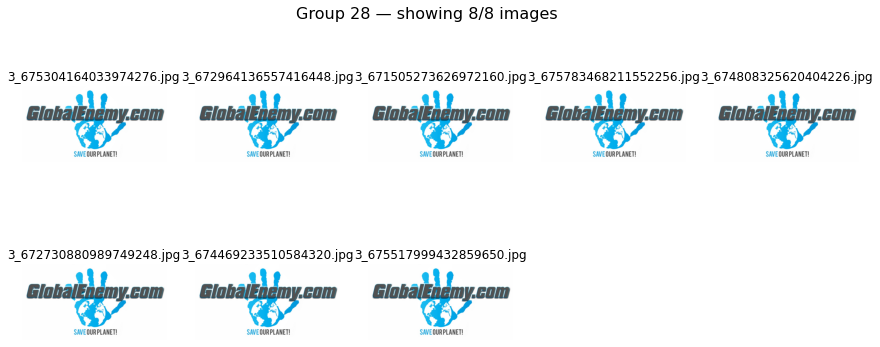

In [ ]:
# see other groups
show_group_images(28, max_images=20)

In [8]:
import json
import pandas as pd
from pathlib import Path

DATA_DIR = Path("../data")
tweets_path = DATA_DIR / "tweets.dat"

def parse_tweets(path, max_rows=None):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_rows and i >= max_rows:
                break
            try:
                obj = json.loads(line)
                rows.append({
                    "id": obj.get("id"),
                    "author_id": obj.get("author_id"),
                    "text": obj.get("text"),
                    "created_at": obj.get("created_at"),
                    "lang": obj.get("lang"),
                    "referenced_tweets": obj.get("referenced_tweets"),
                    "public_metrics": obj.get("public_metrics"),

                    "attachments": obj.get("attachments"),
                    "entities": obj.get("entities"),
                })
            except Exception:
                continue
    return pd.DataFrame(rows)

tweets_df = parse_tweets(tweets_path, max_rows=None)
print("Parsed tweets:", len(tweets_df))
tweets_df.head()


Parsed tweets: 2260916


,id,author_id,text,created_at,lang,referenced_tweets,public_metrics,attachments,entities
0,675827469119832066,1011975294,RT @MinisterTdB: Climate change won’t stop ove...,2015-12-12T23:59:59.000Z,en,"[{'type': 'retweeted', 'id': '6757779674700390...","{'retweet_count': 107, 'reply_count': 0, 'like...",None,"{'mentions': [{'start': 3, 'end': 15, 'usernam..."
1,675827469006581760,255144027,RT @LaurenceTubiana: I just can believe it !we...,2015-12-12T23:59:59.000Z,en,"[{'type': 'retweeted', 'id': '6757815547450572...","{'retweet_count': 109, 'reply_count': 0, 'like...",None,"{'mentions': [{'start': 3, 'end': 19, 'usernam..."
2,675827468775718912,214748274,RT @COP21en: We did it! #ParisAgreement is ado...,2015-12-12T23:59:59.000Z,en,"[{'type': 'retweeted', 'id': '6757487202442977...","{'retweet_count': 1204, 'reply_count': 0, 'lik...",{'media_keys': ['3_675748710089940992']},"{'mentions': [{'start': 3, 'end': 11, 'usernam..."
3,675827465378504705,449273927,RT @TheGlobalGoals: Incredible news for our wo...,2015-12-12T23:59:58.000Z,en,"[{'type': 'retweeted', 'id': '6757646325990440...","{'retweet_count': 110, 'reply_count': 0, 'like...",None,"{'mentions': [{'start': 3, 'end': 18, 'usernam..."
4,675827465336434688,1601937732,RT @StopShenhua: “The people’s resolve is such...,2015-12-12T23:59:58.000Z,en,"[{'type': 'retweeted', 'id': '6757735596884541...","{'retweet_count': 49, 'reply_count': 0, 'like_...",None,"{'mentions': [{'start': 3, 'end': 15, 'usernam..."


In [ ]:
# extract media_key to tweet_id mapping from tweets_df

media_rows = []

for _, row in tweets_df.iterrows():
    tweet_id = row["id"]

    att = row.get("attachments")
    if isinstance(att, dict) and "media_keys" in att:
        for mk in att["media_keys"]:
            media_rows.append({"media_key": mk, "tweet_id": tweet_id})

    ent = row.get("entities")
    if isinstance(ent, dict) and "media" in ent:
        for item in ent["media"]:
            mk = item.get("media_key")
            if mk:
                media_rows.append({"media_key": mk, "tweet_id": tweet_id})

df_media_map = (
    pd.DataFrame(media_rows)
    .drop_duplicates()
)

print("Media–tweet pairs (full):", len(df_media_map))
df_media_map.head()


Media–tweet pairs (full): 571726


,media_key,tweet_id
0,3_675748710089940992,675827468775718912
1,3_675609306075648000,675827440120233984
2,3_675774413573390337,675827424161087488
3,7_675824682810155008,675827413821984768
4,3_675813573877198849,675827395639836672


In [ ]:
# image_file -> group_id table (only from sample_files)

rows = []
for gid, group in enumerate(groups):
    for img in group:
        rows.append({"image_file": img, "group_id": gid})

df_groups = pd.DataFrame(rows)
print("Rows in df_groups:", len(df_groups))
df_groups.head()


Rows in df_groups: 5000


,image_file,group_id
0,3_675668070577348608.jpg,0
1,3_671607376282304512.jpg,1
2,3_671251127707508738.png,2
3,3_671260869960065024.png,2
4,3_672761417796317184.jpg,3


In [ ]:
# remove .jpg and get media_key
df_groups["media_key"] = df_groups["image_file"].str.replace(r"\.(jpg|jpeg|png|gif)$", "", regex=True)

# keep only media keys corresponding to the sample
df_media_map_sample = df_media_map[df_media_map["media_key"].isin(df_groups["media_key"])]

print("Media–tweet pairs (sample only):", len(df_media_map_sample))
df_media_map_sample.head()


Media–tweet pairs (sample only): 29543


,media_key,tweet_id
0,3_675748710089940992,675827468775718912
4,3_675813573877198849,675827395639836672
18,3_675748710089940992,675827316480745472
34,3_675736141744594944,675827233085263872
41,3_675813573877198849,675827201179299842


In [12]:
df_final = (
    df_groups
    .merge(df_media_map_sample, on="media_key", how="left")
    .drop(columns=["media_key"])
)

print("Final rows:", len(df_final))
df_final.head()


Final rows: 29543


,image_file,group_id,tweet_id
0,3_675668070577348608.jpg,0,675787732753514498
1,3_675668070577348608.jpg,0,675739705812586497
2,3_675668070577348608.jpg,0,675714635786543106
3,3_675668070577348608.jpg,0,675695521550442497
4,3_675668070577348608.jpg,0,675695457906139136


In [13]:
out_path = DATA_DIR / "image_groups_sample_with_tweet.csv"
df_final.to_csv(out_path, index=False)
print("Saved to:", out_path)


Saved to: ../data/image_groups_sample_with_tweet.csv
